In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last layer
model.eval()

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_embeddings_in_batches(file_path, batch_size):
    with open(file_path, 'rb') as f:
        data = pd.read_pickle(f)
    uuids = list(data.keys())
    embeddings = list(data.values())
    for i in range(0, len(embeddings), batch_size):
        yield uuids[i:i + batch_size], embeddings[i:i + batch_size]

def compute_embedding(img_path, model):
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(img_tensor)
    embedding = embedding.view(-1).numpy()  # Flatten the embedding
    return embedding

def find_top_similar_images(embedding, embeddings_batches, top_n=5):
    all_similarities = []
    all_uuids = []
    
    for uuids_batch, embeddings_batch in embeddings_batches:
        similarities = cosine_similarity([embedding], embeddings_batch)[0]
        all_similarities.extend(similarities)
        all_uuids.extend(uuids_batch)
    
    all_similarities = np.array(all_similarities)
    top_indices = all_similarities.argsort()[-top_n:][::-1]
    return [all_uuids[i] for i in top_indices]

def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

def plot_images(main_image_path, top_similar_images_paths):
    plt.figure(figsize=(20, 10))
    
    main_image = cv2.imread(main_image_path)
    if main_image is None:
        raise ValueError(f"Main image not found at path: {main_image_path}")
    main_image = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(top_similar_images_paths) + 1, 1)
    plt.imshow(main_image)
    plt.title('Input Image')
    plt.axis('off')
    
    for i, img_path in enumerate(top_similar_images_paths):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Similar image not found at path: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(top_similar_images_paths) + 1, i + 2)
        plt.imshow(img)
        plt.title(f'Similar Image {i+1}')
        plt.axis('off')
    
    plt.show()

# Example usage
input_image_path = "new_images/Food.jpg"  # Path to the input image
cosine_similarities_path = "combined_embeddings.pkl"  # Path to precomputed dataset embeddings
database_path = "image_metadata.db"  # Path to the database
batch_size = 1000  # Adjust batch size according to memory capacity

# Compute embedding for the new image
print(f"Computing embedding for the new image: {input_image_path}")
new_image_embedding = compute_embedding(input_image_path, model)
print("Embedding computed.")

# Load embeddings in batches and find top similar images
print("Finding top similar images...")
embeddings_batches = load_embeddings_in_batches(cosine_similarities_path, batch_size)
top_similar_images = find_top_similar_images(new_image_embedding, embeddings_batches)
print(f"Top similar images: {top_similar_images}")

# Load image paths from the database
print("Loading image paths from the database...")
image_paths_dict = load_image_paths_from_db(database_path, top_similar_images)
print(f"Image paths loaded: {image_paths_dict}")

# Get the paths for the similar images
top_similar_images_paths = [image_paths_dict[uuid] for uuid in top_similar_images]
print(f"Top similar images paths: {top_similar_images_paths}")

# Plot the images
print("Plotting images...")
plot_images(input_image_path, top_similar_images_paths)
print("Images plotted.")


In [ ]:
import os
import pickle
import sqlite3
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the histograms from the pickle file
def load_histograms(pickle_file):
    with open(pickle_file, 'rb') as f:
        histograms = pickle.load(f)
    return histograms

# Compare histograms using different methods
def compare_histograms(hist1, hist2, method='correlation'):
    if hist1.shape != hist2.shape:
        raise ValueError("Histograms must have the same shape for comparison.")
    
    if method == 'correlation':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    elif method == 'chi-square':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    elif method == 'intersection':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    elif method == 'bhattacharyya':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

# Preprocess histogram to ensure consistent shape
def preprocess_histogram(hist, bin_size=(16, 16, 16), ranges=[0, 256, 0, 256, 0, 256]):
    hist = cv2.calcHist([hist], [0, 1, 2], None, bin_size, ranges)
    cv2.normalize(hist, hist)
    return hist.flatten()

# Find the top similar images
def find_top_color_similar_images(target_hist, histograms, top_n=5, method='correlation', batch_size=1000):
    all_uuids = list(histograms.keys())
    similarities = []

    # Process in batches
    for i in tqdm(range(0, len(all_uuids), batch_size)):
        batch_uuids = all_uuids[i:i+batch_size]
        batch_histograms = [histograms[uuid] for uuid in batch_uuids]
        batch_similarities = []
        for hist in batch_histograms:
            try:
                similarity = compare_histograms(target_hist, hist, method)
                batch_similarities.append(similarity)
            except ValueError as e:
                print(f"Error comparing histograms: {e}")
                batch_similarities.append(float('-inf') if method in ['correlation', 'intersection'] else float('inf'))
        similarities.extend(batch_similarities)

    # For 'correlation' and 'intersection', higher score means more similar; for others, lower score means more similar
    if method in ['correlation', 'intersection']:
        top_similar_indices = np.argsort(similarities)[-top_n:]
    else:
        top_similar_indices = np.argsort(similarities)[:top_n]
    
    top_similar_uuids = [all_uuids[idx] for idx in top_similar_indices]
    return top_similar_uuids

# Plot images
def plot_images(input_image_path, similar_image_paths, method):
    fig, axes = plt.subplots(1, len(similar_image_paths) + 1, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB))
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    for i, img_path in enumerate(similar_image_paths):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        axes[i+1].imshow(img)
        axes[i+1].set_title(f'Similar Image {i+1}')
        axes[i+1].axis('off')

    plt.suptitle(f'Top Similar Images using {method} method')
    plt.show()

# Load image paths from the database
def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

def main():
    pickle_file = "combined_color_histograms.pkl"  # Replace with your actual file path
    input_image_path = "new_images/try4.jpg"  # Replace with your actual input image path
    database_path = "image_metadata.db" 
    
    # Load the histograms from the pickle file
    histograms = load_histograms(pickle_file)

    # Compute the histogram for the input image
    input_image = cv2.imread(input_image_path)
    if input_image is None:
        raise ValueError(f"Unable to read image at path {input_image_path}")
    input_hist = preprocess_histogram(input_image)

    # Find top similar images for different methods
    methods = ['correlation']
    for method in methods:
        top_similar_uuids = find_top_color_similar_images(input_hist, histograms, top_n=5, method=method)
        image_paths_dict = load_image_paths_from_db(database_path, top_similar_uuids)
        top_similar_image_paths = [image_paths_dict[uuid] for uuid in top_similar_uuids]
        print(f"Top similar images using {method} method: {top_similar_uuids}")
        plot_images(input_image_path, top_similar_image_paths, method)

if __name__ == "__main__":
    main()


c:\Users\Lupo\anaconda3\envs\big_data\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator IncrementalPCA from version 1.3.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Computing embedding for the new image: new_images/pengu.jpg
Embedding computed.
Finding top similar images...
Top similar images: ['7f401156-1c1f-456a-b7e7-43ea0d6183b7', 'd871fc14-39ea-40f8-8d0e-b69b3aed4791', '8ee499c4-9d84-466d-a1af-03ad8192cc6e', '84a15395-1ce2-4897-9d0c-41b92d777200', '4f65ea90-6387-4de5-b0b6-5e59b249c59c']
Loading image paths from the database...
Image paths loaded: {'d871fc14-39ea-40f8-8d0e-b69b3aed4791': 'E:/data/image_data\\coco2017_unlabeled\\unlabeled2017\\000000074879.jpg', '8ee499c4-9d84-466d-a1af-03ad8192cc6e': 'E:/data/image_data\\coco2017_unlabeled\\unlabeled2017\\000000238574.jpg', '7f401156-1c1f-456a-b7e7-43ea0d6183b7': 'E:/data/image_data\\coco2017_train\\train2017\\000000148859.jpg', '4f65ea90-6387-4de5-b0b6-5e59b249c59c': 'E:/data/image_data\\coco2017_train\\train2017\\000000291114.jpg', '84a15395-1ce2-4897-9d0c-41b92d777200': 'E:/data/image_data\\coco2017_train\\train2017\\000000475465.jpg'}
Top similar images paths: ['E:/data/image_data\\coco2017

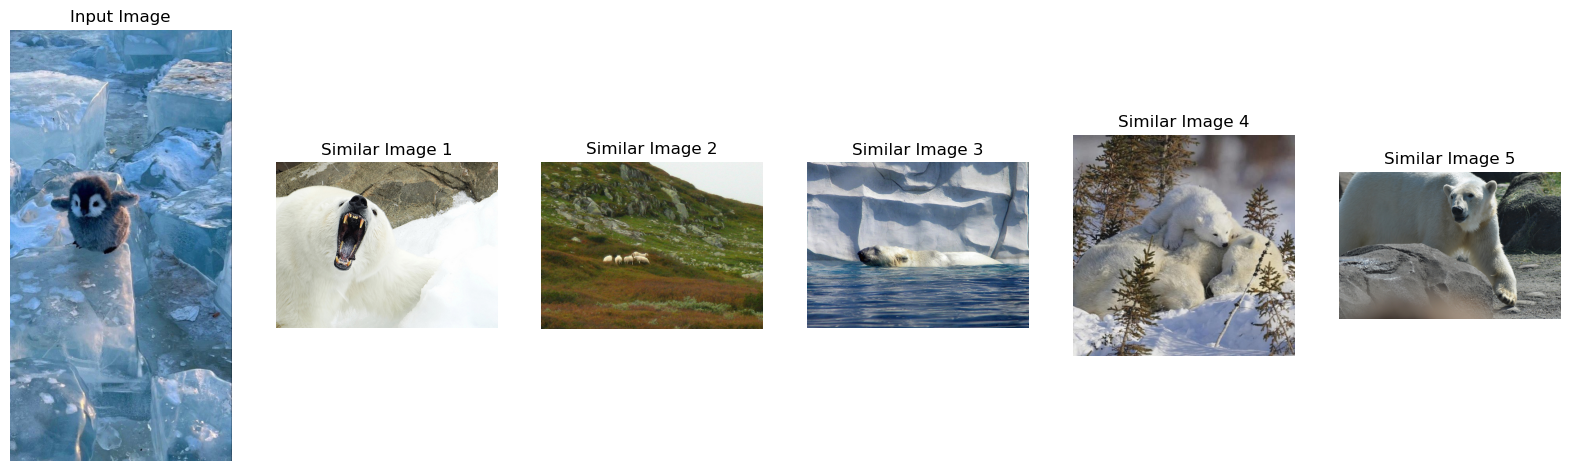

Images plotted.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import torch
from torchvision import models, transforms
from PIL import Image
import pickle

# Load pre-trained ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last layer
model.eval()

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_embeddings_in_batches(file_path, batch_size):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    uuids = list(data.keys())
    embeddings = list(data.values())
    for i in range(0, len(embeddings), batch_size):
        yield uuids[i:i + batch_size], embeddings[i:i + batch_size]

def compute_embedding(img_path, model):
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(img_tensor)
    embedding = embedding.view(-1).numpy()  # Flatten the embedding
    return embedding

def find_top_similar_images(embedding, embeddings_batches, pca, top_n=5):
    embedding_pca = pca.transform([embedding])
    all_similarities = []
    all_uuids = []
    
    for uuids_batch, embeddings_batch in embeddings_batches:
        similarities = cosine_similarity(embedding_pca, embeddings_batch)[0]
        all_similarities.extend(similarities)
        all_uuids.extend(uuids_batch)
    
    all_similarities = np.array(all_similarities)
    top_indices = all_similarities.argsort()[-top_n:][::-1]
    return [all_uuids[i] for i in top_indices]

def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

def plot_images(main_image_path, top_similar_images_paths):
    plt.figure(figsize=(20, 10))
    
    main_image = cv2.imread(main_image_path)
    if main_image is None:
        raise ValueError(f"Main image not found at path: {main_image_path}")
    main_image = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(top_similar_images_paths) + 1, 1)
    plt.imshow(main_image)
    plt.title('Input Image')
    plt.axis('off')
    
    for i, img_path in enumerate(top_similar_images_paths):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Similar image not found at path: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(top_similar_images_paths) + 1, i + 2)
        plt.imshow(img)
        plt.title(f'Similar Image {i+1}')
        plt.axis('off')
    
    plt.show()

# Example usage
input_image_path = "new_images/pengu.jpg"  # Path to the input image
pca_embeddings_path = "pca_embeddings.pkl"  # Path to PCA-reduced dataset embeddings
pca_model_path = "pca_model.pkl"  # Path to the saved PCA model
database_path = "image_metadata.db"  # Path to the database
batch_size = 1000  # Adjust batch size according to memory capacity

# Load PCA model
with open(pca_model_path, 'rb') as f:
    pca = pickle.load(f)

# Compute embedding for the new image
print(f"Computing embedding for the new image: {input_image_path}")
new_image_embedding = compute_embedding(input_image_path, model)
print("Embedding computed.")

# Load embeddings in batches and find top similar images
print("Finding top similar images...")
embeddings_batches = load_embeddings_in_batches(pca_embeddings_path, batch_size)
top_similar_images = find_top_similar_images(new_image_embedding, embeddings_batches, pca)
print(f"Top similar images: {top_similar_images}")

# Load image paths from the database
print("Loading image paths from the database...")
image_paths_dict = load_image_paths_from_db(database_path, top_similar_images)
print(f"Image paths loaded: {image_paths_dict}")

# Get the paths for the similar images
top_similar_images_paths = [image_paths_dict[uuid] for uuid in top_similar_images]
print(f"Top similar images paths: {top_similar_images_paths}")

# Plot the images
print("Plotting images...")
plot_images(input_image_path, top_similar_images_paths)
print("Images plotted.")
